In [2]:
import os
from astropy.table import Table
import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

In [3]:
import desisim
import desisurvey
import desimodel.io
import desimodel.footprint

# Environment Variables 

Set some environment variables and create output directories

`$DESISURVEY` = `${SCRATCH}`/quicksurvey_example/survey/

In [4]:
basedir = os.path.join(os.getenv('SCRATCH'),'quicksurvey_example')
surveydir = os.environ['DESISURVEY'] = os.path.join(basedir,'survey')
print(os.environ['DESISURVEY'])

/global/cscratch1/sd/forero/quicksurvey_example/survey


In [5]:
targetdir = os.path.join(basedir,'targets')
nospectradir = os.path.join(targetdir,'no_spectra')
fullspectradir = os.path.join(targetdir,'full_spectra')
zcatbrightdir = os.path.join(basedir,'zcat/bright')
zcatdarkdir = os.path.join(basedir,'zcat/dark')
os.makedirs(targetdir, exist_ok=True)
os.makedirs(zcatbrightdir, exist_ok=True)
os.makedirs(zcatdarkdir, exist_ok=True)
os.makedirs(nospectradir, exist_ok=True)
os.makedirs(fullspectradir, exist_ok=True)

# Run select_mock_targets

In [6]:
tilefile = os.path.join(targetdir, 'test-tiles.fits')
configfile = os.path.join(targetdir,'select-mock-targets.yaml')
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -O {outputdir} --config {configfile}"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
cmd = cmd.format(outputdir=fullspectradir, tilefile=tilefile, configfile=configfile)
print(cmd) 

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra --config /global/cscratch1/sd/forero/quicksurvey_example/targets/select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/forero/quicksurvey_example/targets/test-tiles.fits


In [7]:
#!$cmd

In [39]:
cmd = "join_mock_targets --mockdir {} --force".format(fullspectradir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra --force
INFO:build.py:967:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/sky.fits
INFO:build.py:967:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/standards-dark.fits
INFO:build.py:967:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/standards-bright.fits
INFO:build.py:967:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/targets.fits
INFO:build.py:967:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/truth.fits
INFO:build.py:1039:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/full_spectra/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.051

In [9]:
tilefile = os.path.join(targetdir, 'test-tiles.fits')
configfile = os.path.join(targetdir,'select-mock-targets.yaml')
os.environ['MPICH_GNI_FORK_MODE'] = 'FULLCOPY'
os.environ['KMP_AFFINITY'] = 'disabled'
os.environ['OMP_NUM_THREADS'] = '1'
cmd = "srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00"
cmd += " mpi_select_mock_targets -O {outputdir} --config {configfile}"
cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile} --no-spectra"
cmd = cmd.format(outputdir=nospectradir, tilefile=tilefile, configfile=configfile)
print(cmd)

srun -N 15 -n 30 -c 16 -p debug -C haswell -t 00:30:00 mpi_select_mock_targets -O /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra --config /global/cscratch1/sd/forero/quicksurvey_example/targets/select-mock-targets.yaml --seed 1 --nproc 16 --nside 64 --tiles /global/cscratch1/sd/forero/quicksurvey_example/targets/test-tiles.fits --no-spectra


In [10]:
# !$cmd

In [45]:
cmd = "join_mock_targets --mockdir {} --force".format(nospectradir)
print(cmd)
!$cmd

join_mock_targets --mockdir /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra --force
INFO:build.py:974:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/sky.fits
INFO:build.py:974:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/standards-dark.fits
INFO:build.py:974:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/standards-bright.fits
INFO:build.py:974:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/targets.fits
INFO:build.py:974:merge_file_tables: Writing /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/truth.fits
INFO:build.py:1046:join_targets_truth: Generating merged target list /global/cscratch1/sd/forero/quicksurvey_example/targets/no_spectra/mtl.fits
DEBUG: before targets.calc_priority slow copy
DEBUG: seconds for targets.calc_priority slow copy: 0.04944086074829101

In [12]:
# some sanity checks on the results

In [46]:
targetdir = nospectradir
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [54]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth arerow matched
print(len(targets), len(np.unique(targets['TARGETID'])))
print(len(sky), len(np.unique(sky['TARGETID'])))
print(len(std), len(np.unique(std['TARGETID'])))
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


273947 273517
64189 64150
1884 1884


AssertionError: 

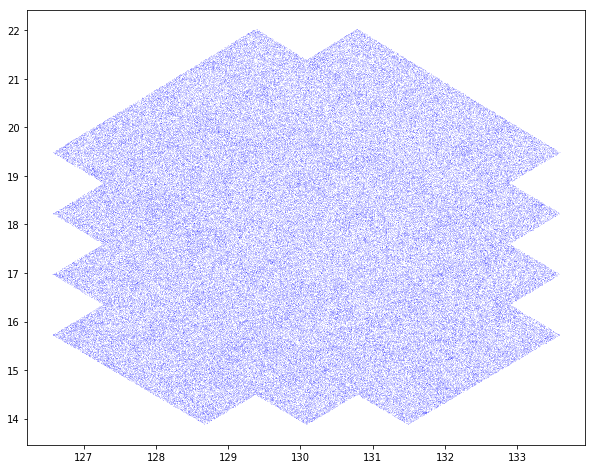

In [55]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)

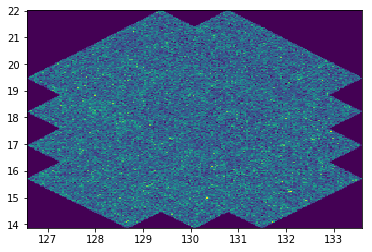

In [49]:
a = plt.hist2d(mtl['RA'], mtl['DEC'], bins=200)

In [40]:
targetdir = fullspectradir
targets = fitsio.read(targetdir+'/targets.fits')
truth   = fitsio.read(targetdir+'/truth.fits')
mtl     = fitsio.read(targetdir+'/mtl.fits')
std     = fitsio.read(targetdir+'/standards-dark.fits')
sky     = fitsio.read(targetdir+'/sky.fits')

In [41]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth arerow matched
print(len(targets), len(np.unique(targets['TARGETID'])))
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


277494 276995


AssertionError: 

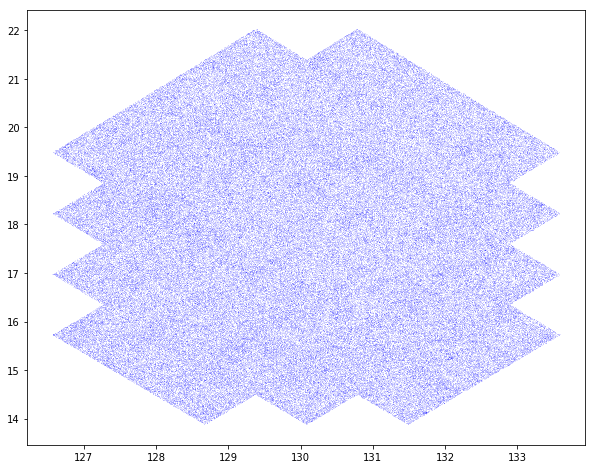

In [37]:
plt.figure(figsize=(10,8))
plt.plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
#plt.plot(std['RA'], std['DEC'], 'm.')

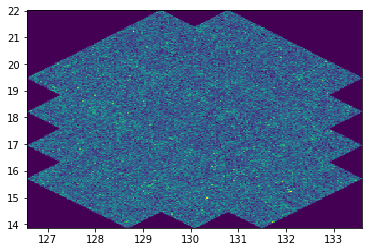

In [38]:
a = plt.hist2d(mtl['RA'], mtl['DEC'], bins=200)